In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["font.family"] = "serif"

### **Setting 1**

**Load ground truth and credible intervals:**

In [2]:
setting1 = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

confidence_levels = setting1["confidence_levels"]
shear1_true = setting1["shear1_true"]
shear2_true = setting1["shear2_true"]
shear1_ci_lower = setting1["shear1_ci_lower"]
shear1_ci_upper = setting1["shear1_ci_upper"]
shear2_ci_lower = setting1["shear2_ci_lower"]
shear2_ci_upper = setting1["shear2_ci_upper"]

**Compute empirical coverage**

In [3]:
shear1_coverage_probs = (
    (
        (shear1_ci_lower <= shear1_true.unsqueeze(-1))
        * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)
    )
    .float()
    .mean(0)
)
shear2_coverage_probs = (
    (
        (shear2_ci_lower <= shear2_true.unsqueeze(-1))
        * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)
    )
    .float()
    .mean(0)
)

In [4]:
for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0531, Shear 2: 0.0425
Confidence level: 0.10, Shear 1: 0.1079, Shear 2: 0.0867
Confidence level: 0.15, Shear 1: 0.1603, Shear 2: 0.1275
Confidence level: 0.20, Shear 1: 0.2081, Shear 2: 0.1707
Confidence level: 0.25, Shear 1: 0.2583, Shear 2: 0.2120
Confidence level: 0.30, Shear 1: 0.3052, Shear 2: 0.2522
Confidence level: 0.35, Shear 1: 0.3588, Shear 2: 0.2942
Confidence level: 0.40, Shear 1: 0.4100, Shear 2: 0.3398
Confidence level: 0.45, Shear 1: 0.4624, Shear 2: 0.3835
Confidence level: 0.50, Shear 1: 0.5124, Shear 2: 0.4345
Confidence level: 0.55, Shear 1: 0.5622, Shear 2: 0.4806
Confidence level: 0.60, Shear 1: 0.6123, Shear 2: 0.5313
Confidence level: 0.65, Shear 1: 0.6628, Shear 2: 0.5807
Confidence level: 0.70, Shear 1: 0.7119, Shear 2: 0.6324
Confidence level: 0.75, Shear 1: 0.7600, Shear 2: 0.6886
Confidence level: 0.80, Shear 1: 0.8123, Shear 2: 0.7463
Confidence level: 0.85, Shear 1: 0.8554, Shear 2: 0.8033
Confidence level: 0.90, Shear 1

**Plot nominal vs. empirical coverage**

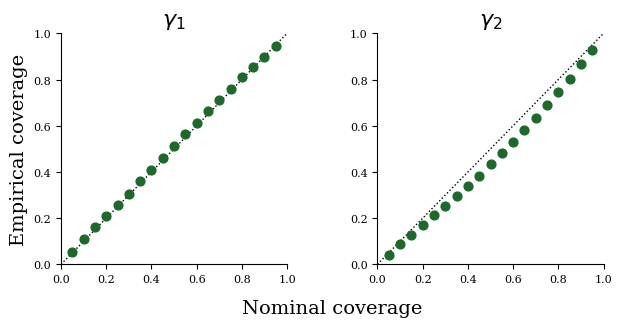

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fontsize = 14
ticklabelsize = 8
color = "#1c692b"
s = 40

_ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color=color, s=s, zorder=1)
_ = ax[0].set_title(r"$\gamma_1$", fontsize=16)
_ = ax[0].set_xlabel("Nominal coverage", fontsize=fontsize)
_ = ax[0].xaxis.set_label_coords(1.2, -0.15)
_ = ax[0].set_ylabel("Empirical coverage", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color=color, s=s, zorder=1)
_ = ax[1].set_title(r"$\gamma_2$", fontsize=16)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

fig.subplots_adjust(wspace=0.4)

fig.savefig(
    "figures/npe_coverageprobs_setting1.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

**Plot 90% credible intervals**

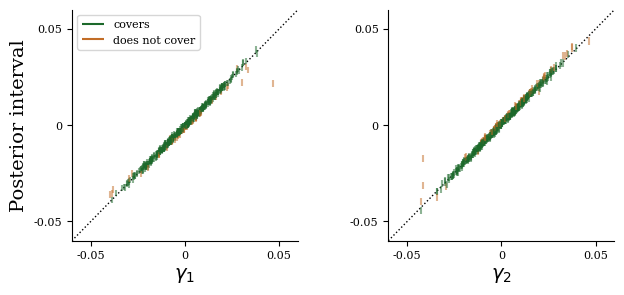

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fontsize = 14
ticklabelsize = 8
color = np.array(["#c26d27", "#1c692b"])
alpha = 0.5

axmin = -0.06
axmax = 0.06

np.random.seed(0)
n_samples = len(shear1_true)
indexes = np.random.choice(n_samples, 500, replace=False)

interval_idx = 17  # 90% credible interval

_ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
shear1_coverage = (
    (shear1_ci_lower <= shear1_true.unsqueeze(-1)) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)
)[..., interval_idx]

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
            label="covers",
        )
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
            label="does not cover",
        )
    else:
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
        )
_ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
_ = ax[0].set_ylabel(r"Posterior interval", fontsize=fontsize)
_ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[0].legend(loc="upper left", prop={"size": ticklabelsize})
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)


_ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
shear2_coverage = (
    (shear2_ci_lower <= shear2_true.unsqueeze(-1)) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)
)[..., interval_idx]

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
            label="covers",
        )
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
            label="does not cover",
        )
    else:
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
        )
_ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
_ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)

leg = ax[0].legend(loc="upper left", prop={"size": ticklabelsize})
for lh in leg.legend_handles:
    lh.set_alpha(1)
for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)

for a in ax.flat:
    _ = a.spines[["top", "right"]].set_visible(False)
    _ = a.set_xlim(axmin, axmax)
    _ = a.set_ylim(axmin, axmax)
    _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
    _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
    _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

fig.subplots_adjust(wspace=0.4)

fig.savefig(
    "figures/npe_credibleintervals_setting1.png",
    dpi=600,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)